# Classifiez automatiquement des biens de consommation
 1ere partie : EDA NLP manuel  - CountVectorizer et TF-IDF
Mission
Ta mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

Tu dois analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images, une réduction de dimension, puis un clustering. Les résultats de la réduction de dimension et du clustering seront à présenter sous la forme de graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories réelles et les clusters. Ces résultats illustreront le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

Pourrais-tu nous démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des produits de même catégorie ?

Voici les contraintes : 

Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
une approche de type word/sentence embedding avec BERT ;
une approche de type word/sentence embedding avec USE (Universal Sentence Encoder). 

# Import

In [1]:
import os, sys, time, random
import pandas as pd
import numpy as np

import os
import random
import re #Opération de base sur les expressions rationnelles
import string

#NLP
import nltk
from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer, wordpunct_tokenize
#from nltk import clean_html
# Lemmatizer (base d'un mot)
from nltk import chunk 
from nltk.corpus import words
from nltk.corpus import stopwords

from nltk.stem import *
from nltk.stem import PorterStemmer
from nltk.util import clean_html


#Viz - Représentation graphique
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

#Exécuter le code sur plusieurs CPU pour gagener du temps
from pandarallel import pandarallel

import re #regex library expressions régulières

from sklearn import preprocessing

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, pairwise
from sklearn.metrics.pairwise import distance_metrics

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE

from sklearn import preprocessing, decomposition, manifold, metrics, datasets, cluster
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import adjusted_rand_score

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.feature_extraction.text import CountVectorizer

#nltk.download("stopwords")
#nltk.download("punkt")
#!pip install gtts

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

In [2]:
from P6_NLP_functions import *
#Relancer le noyau Anaconda qd on crée la fct pour la 1ere fois

In [3]:
import multiprocessing
workers=multiprocessing.cpu_count()
workers

8

In [4]:
#Initialiser pandarallel pour travailler sur 6 CPU
pandarallel.initialize(progress_bar=True, 
                       nb_workers=8
                      # verbose=1
                      )

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


Setting pandas display and matplotlib options.

In [5]:
# to show more cells while displaying pandas dataframe
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

# to set the figures background to white
plt.rcParams['figure.facecolor']='w'

To play audio text-to-speech during execution.

Graphic and option

In [6]:
sns.set()

https://spacy.io/usage/spacy-101

Il faut comprendre cette vidéo la rupture entre les stats et l'embedding senss global
https://www.youtube.com/watch?v=CsQNF9s78Nc&ab_channel=ScienceEtonnante

# Data Assessment

In [7]:
path = 'C:/Users/ADSL/Documents/Projet 6/datas/cleaned/' # 
df= pd.read_csv(path + "flipkart_com_cleaned.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')

In [8]:
df.shape

(1050, 5)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 55b85ea15a1536d46b7190ad6fff8ce7 to f2f027ad6a6df617c9f125173da71e44
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             1050 non-null   object
 1   description          1050 non-null   object
 2   description_bow      1050 non-null   object
 3   description_bow_lem  1050 non-null   object
 4   description_dl       1050 non-null   object
dtypes: object(5)
memory usage: 49.2+ KB


In [10]:
df.sample(2)

,category,description,description_bow,description_bow_lem,description_dl
uniq_id,,,,,
833a87b0af3b84fe246d2ebf271af177,Computers,Zyxel PLA-4205 Buy Zyxel PLA-4205 only for Rs. 8100 from Flipkart.com. Only Genuine Products. 30...,zyxel pla 4205 buy zyxel pla 4205 8100 flipkart.com only genuine products day replacement guaran...,zyxel pla 4205 buy zyxel pla 4205 8100 flipkart.com only genuine product day replacement guarant...,zyxel pla 4205 buy zyxel pla 4205 only for rs . 8100 from flipkart.com . only genuine products ....
55195de3873fffaa9e37b041533d7305,Kitchen,Philips 9.5 W LED B22 3000K A55 IND Bulb Buy Philips 9.5 W LED B22 3000K A55 IND Bulb for Rs.419...,philips 9.5 led b22 3000k a55 ind bulb buy philips 9.5 led b22 3000k a55 ind bulb rs.419 online ...,philips 9.5 lead b22 3000k a55 ind bulb buy philips 9.5 lead b22 3000k a55 ind bulb rs.419 onlin...,philips 9.5 w led b22 3000k a55 ind bulb buy philips 9.5 w led b22 3000k a55 ind bulb for rs.419...


In [11]:
df.loc['a43fbae655e5d13215b9dd65339fa9d4'].description_bow

'huawei ws331c 300 mbps wireless range extender buy huawei ws331c 300 mbps wireless range extender 2250 flipkart.com only genuine products day replacement guarantee free shipping cash delivery'

In [12]:
df.loc['4a1b23dacd7d2a9ec7414f7159f25a48'].description_dl

'mars queen eye liner , lip gloss , eyeliner mars queen eye liner , lip gloss , eyeliner ( set of 3 ) price : rs . 299 1 queen eye liner , 1 lip gloss , 1 eyeliner , specifications of mars queen eye liner , lip gloss , eyeliner ( set of 3 ) combo set details number of contents in combo set 3 combo set contents 1 queen eye liner , 1 lip gloss , 1 eyeliner ideal for women organic no general traits professional care yes gift pack yes'

In [13]:
df.loc['d21409978f5e404b53f89e444f7893fe'].description_bow

'sonata 7991pp02 ocean digital watch for men sonata 7991pp02 ocean digital watch for men buy sonata 7991pp02 ocean digital watch for men 7991pp02 online rs.999 india only flipkart.com water resistant round dial black strap great discounts only genuine products day replacement guarantee free shipping cash delivery'

In [14]:
df.loc['d21409978f5e404b53f89e444f7893fe'].description_dl

'sf by sonata 7991pp02 ocean digital watch for men sf by sonata 7991pp02 ocean digital watch for men buy sf by sonata 7991pp02 ocean digital watch for men 7991pp02 online at rs.999 in india only at flipkart.com . water resistant , round dial , black strap great discounts , only genuine products , 30 day replacement guarantee , free shipping . cash on delivery !'

## Fonctions communes

In [15]:
# Les catégories des produits
l_cat = list(set(df['category']))
print("catégories : ", l_cat)
#transforme les catégories en format numérique
y_cat_num = [(1-l_cat.index(df.iloc[i]['category'])) for i in range(len(df))]

catégories :  ['Home', 'Watches', 'Computers', 'Beauty', 'Kitchen', 'Baby', 'Furnishing']


In [16]:
len(y_cat_num)

1050

In [17]:
len(l_cat)

7

In [18]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne en utlisant le Kmeans
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)


In [19]:
corpus = df.description_bow.values

## Fonctions communes

In [20]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

## Création du modèle Word2Vec

In [21]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to lengt of sentences
sentences = df['description_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [22]:
len(sentences)

1050

In [23]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=8)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4471
Word2Vec trained


In [24]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4472


## Création de la matrice d'embedding

In [25]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4472, 300)


## Création du modèle d'embedding

In [26]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1341600   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,341,600
Trainable params: 1,341,600
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [27]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 1ms/step


(1050, 300)

In [28]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.1833 time :  7.0


description_bow_lem
ARI = 0.26. Chute brutale p/r tf-idf (ARI 0.55)

description_bow_lem (spacy)
ARI = 0.18

description_bow
ARI = 0.25. Chute brutale p/r tf-idf (ARI 0.54)

description_dl
ARI = 0.24. Chute brutale p/r tf-idf (ARI 0.54)

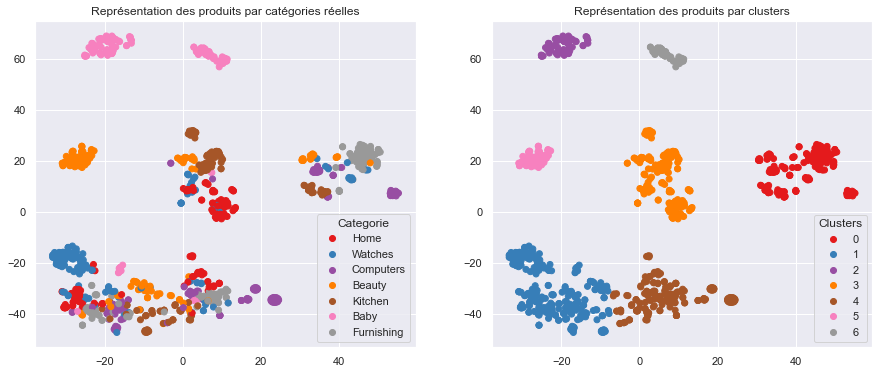

ARI :  0.1833


In [29]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [30]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [31]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

C:\Users\ADSL\anaconda3\lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
C:\Users\ADSL\anaconda3\lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [32]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.11.0
2.11.0
Num GPUs Available:  0
False


In [33]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [34]:
df.sample(1)

,category,description,description_bow,description_bow_lem,description_dl
uniq_id,,,,,
964648862f322b2cc153239af04b22ef,Computers,ARB Toshiba Dynabook SS MX/395LS Compatible Black 6 Cell Laptop Battery Buy ARB Toshiba Dynabook...,arb toshiba dynabook 395ls compatible black cell laptop battery buy arb toshiba dynabook 395ls c...,arb toshiba dynabook 395ls compatible black cell laptop battery buy arb toshiba dynabook 395ls c...,arb toshiba dynabook ss mx 395ls compatible black 6 cell laptop battery buy arb toshiba dynabook...


In [56]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['description_dl'].to_list()

In [36]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 772ms/step
temps traitement :  102.0


In [37]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.4374 time :  10.0


description_dl
ARI = 0.44 mieux que Word2Vec mais moins bien que tf-idf

description_bow_lem
ARI = 0.40 mieux que Word2Vec mais moins bien que tf-idf

description_bow
ARI = 0.40 mieux que Word2Vec mais moins bien que tf-idf

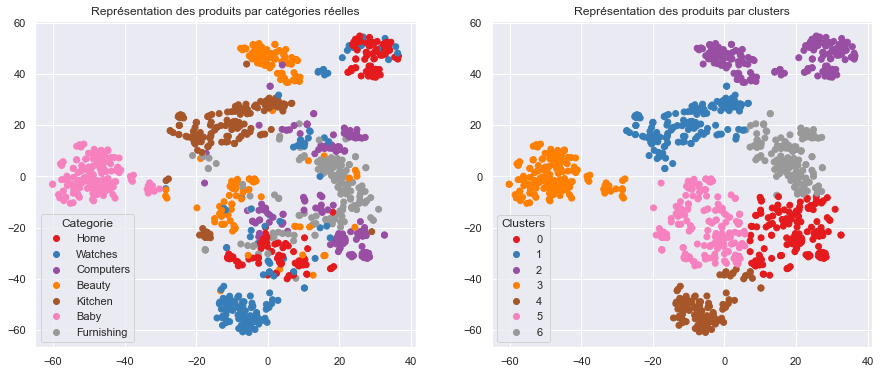

ARI :  0.4374


In [38]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE (Universal Sentence Encoder)

In [47]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [48]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.11.0
2.11.0
Num GPUs Available:  0
False


In [51]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [57]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

batch_size = 10
sentences = df['description_dl'].to_list()

In [58]:
features_USE = feature_USE_fct(sentences, batch_size)

In [59]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.4028 time :  7.0


ARI :  0.4028 moins performant que Bert et Word2vec

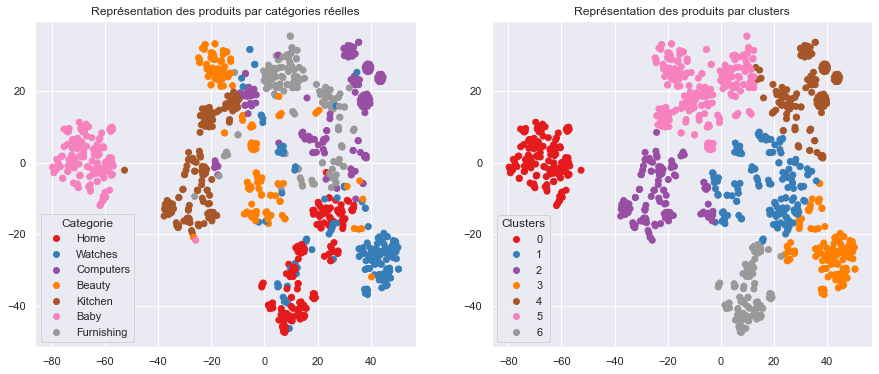

ARI :  0.4028


In [60]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Confusion matrix

In [45]:
df_res_clust = pd.DataFrame()
df_res_clust['category'] = df['category']
df_res_clust

,category
uniq_id,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing
7b72c92c2f6c40268628ec5f14c6d590,Baby
64d5d4a258243731dc7bbb1eef49ad74,Baby
d4684dcdc759dd9cdf41504698d737d8,Furnishing
6325b6870c54cd47be6ebfbffa620ec7,Furnishing
...,...
958f54f4c46b53c8a0a9b8167d9140bc,Baby
fd6cbcc22efb6b761bd564c28928483c,Baby
5912e037d12774bb73a2048f35a00009,Baby


## Objectifs du 15/02
Attention : La façon dont a fait nos classes peut-etre ça a des biais intrinsèques pr/ au réél. Le 6 classes est ce que la façon de travailler les données ou 
Il faut boucler la partie NLP
Grandes lignes OK

Partie 1 :
comment on peut améliorer avec PCA ou TSTD 
Regarder la version supervisée
Random Forest
finir cette partie

Partie 2: 
Faire la matrice de confusion
Vérifier si des confusions de classe
Utiliser POS
Lemaatizer Spacy

Note book le plus propre sur le EMbedding/ Vérfier si un gain significatif 
fct de transo de texte en un vecteur

 # Utiliser TSVD

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB

# make a synthetic dataset
#X, y = make_circles(factor=0.5, random_state=0, noise=0.05)

# use RandomTreesEmbedding to transform data - Pas besoin de transformer
#hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
#X_transformed = hasher.fit_transform(X)

X_transformed = X

# Visualize result after dimensionality reduction using truncated SVD
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X_transformed)


# Learn a Naive Bayes classifier on the transformed data
nb = BernoulliNB()
nb.fit(X_transformed, labels)


# Learn an ExtraTreesClassifier for comparison
trees = ExtraTreesClassifier(max_depth=3, n_estimators=10, random_state=0)
trees.fit(X, labels)

# scatter plot of original and reduced data
fig = plt.figure(figsize=(9, 8))
'''
ax = plt.subplot(221)
ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, edgecolor="k")
ax.set_title("Original Data (2d)")
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(222)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=50, edgecolor="k")
ax.set_title(
    "Truncated SVD reduction (2d) of transformed data (%dd)" % X_transformed.shape[1]
)
ax.set_xticks(())
ax.set_yticks(())

# Plot the decision in original space. For that, we will assign a color
# to each point in the mesh [x_min, x_max]x[y_min, y_max].
h = 0.01
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# transform grid using RandomTreesEmbedding
transformed_grid = hasher.transform(np.c_[xx.ravel(), yy.ravel()])
y_grid_pred = nb.predict_proba(transformed_grid)[:, 1]

ax = plt.subplot(223)
ax.set_title("Naive Bayes on Transformed data")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor="k")
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

# transform grid using ExtraTreesClassifier
y_grid_pred = trees.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

ax = plt.subplot(224)
ax.set_title("ExtraTrees predictions")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor="k")
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

plt.tight_layout()
plt.show()
'''

In [ ]:
X_reduced

In [ ]:
X_reduced.shape

In [ ]:
X_transformed

In [ ]:
X_reduced[:, 0]

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np
np.random.seed(0)
X_dense = X
#X_dense[:, 2 * np.arange(50)] = 0
X = csr_matrix(X_dense)
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(X)

print(svd.explained_variance_ratio_) ### Pourcentage de variance expliquée pour chacune des composantes.

print(svd.explained_variance_ratio_.sum()) # # Les  variables cumulées représentent Somme des % de la variance expliquée

print(svd.singular_values_) #valeur sigulière

In [ ]:
## Pourcentage de variance expliquée
svd.explained_variance_ratio_ 
##nous donne le pourcentage de variance expliquée par chacune des composantes.

In [ ]:
#Projeter les données initiales sur 2 axes
X_transformed = svd.transform(X)

In [ ]:
X_transformed.shape

In [ ]:
n_comp=5
svd = decomposition.PCA(n_components=n_comp) 
#pca.fit(X)

In [ ]:
svd

#Choix du nombre de composantes maximum à calculer pour l'ACP
n_comp=5

#Sélection des colonnes à prendre dans l'ACP - Des variables quantitatives
data_pca = mydata

#préparation des données de l'ACP
#data_pca = data_pca.fillna(data_pca.mean()) #Remplacer les valeurs nulles par la moyenne de la variable

X = data_pca.values # On met toutes les valeurs de data_pca dans un array

#Comme l'array X ne permet pas de retenir le nom des colonnes et des lignes, on les sauvegardera dans names et features
names = data_pca.index #les intitulés 
features = data_pca.columns # Toutes les colonnes du dataframe data
#display(features)

# Centrage des données
#std_scale = preprocessing.StandardScaler().fit(X) #Fonction de centrage

# Réduction
#X_scaled = std_scale.transform(X) #fonction de réduction
#display(X_scaled)

#Calcul des composantes principales
#A l'aide de la méthode decomposition, on initialise une objet de type pca qui sera chargé de calculer la composante principale
pca = decomposition.PCA(n_components=n_comp) 
pca.fit(X)

#Diagramme Eboulis des valeurs propres avec cumul
display_scree_plot(pca)

#Cercle des corrélations
pcs = pca.components_   #On met les objets pca dans des nouvelles variables
#display(pcs)
#paramètres : pcs, nb composants, pca, nbre de plans factoriel
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))
plt.show()

In [ ]:
#VT = svd.components_
#VT

In [ ]:
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(X, 
                              n_components=15,
                              n_iter=5,
                              random_state=None)

In [ ]:
U

In [ ]:
U.shape

In [ ]:
Sigma

In [ ]:
Sigma.shape

In [ ]:
VT

In [ ]:
VT.shape

In [ ]:
X.shape

In [ ]:
model.wv.most_similar('genuine')

In [ ]:
model.wv.most_similar('card')

In [ ]:
model.wv.most_similar('watche')